## Training on mfcc features extracted by librosa 

### Extracting features using librosa

In [34]:
# standard 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# libs for audio
from scipy.io import wavfile as wav
import librosa

# Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn import utils
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score


In [3]:
def extract_features_librosa(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) # 40
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [ ]:
# Read Data
df = pd.read_csv("D:/SUTD/ISTD/Term 6/cds/Project/FULL DATASET_edited.csv")
y = df['PHQ_Binary']
x = df['Participant_ID']


features = []

# Audio files with lots of static
prob = [300, 305, 306, 308, 315, 316, 343, 354, 362, 375, 378, 381, 382, 385, 387, 388, 390, 392, 393, 395, 408, 413, 421, 438, 473, 476, 479, 490, 492]
for index, audio_num in enumerate(x):
    if audio_num not in prob:
        try:
            fn = 'D:/SUTD/ISTD/Term 6/cds/Project/Audio/processed/{}_AUDIO_p.wav'.format(audio_num)
            print(fn)
            features.append([audio_num,extract_features_librosa(fn),y[index]])
        except Exception as e:
            print(e)
        """ librosa_audio, librosa_sample_rate = librosa.load(fn)
        scipy_sample_rate, scipy_audio = wav.read(fn) """

featuresdf = pd.DataFrame(features,columns = ['Participant_ID','feature','PHQ8_Binary'])
featuresdf.to_csv('librosa_mfcc_feature.csv')

### Training

#### Read data

In [28]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

data = pd.read_csv("librosa_mfcc_feature_1.csv")

# to convert X (features) to np array
def remove_brackets(s):
    new_s = s[1:-1]
    return new_s

def str_to_np(X):
    new_X = []
    for i in range(len(X)):
        x_i = np.fromstring(X.iloc[i], dtype=float, sep='\t')
        new_X.append(x_i)
    return np.stack( new_X, axis=0 )



data['feature'] = data['feature'].apply(remove_brackets)
X = data['feature']
X = str_to_np(X)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    data['PHQ8_Binary'].values,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE)
#print(X_train)


#### Evaluation

In [29]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

In [30]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

#### K cross

In [31]:
def k_cross(model, X=X_train, y=y_train, k=10, n=1, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

### Models implementation

#### Logistic Regression

In [32]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"power: {i}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"power: {i}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_logreg_f1_model, best_logreg_recall_model = find_best_logreg_model(6)

power: 0: f1 = 0.14190476190476192 > best f1 = -1
power: 0: recall = 0.20357142857142857 > best recall = -1
power: 6: f1 = 0.16333333333333333 > best f1 = 0.14190476190476192
power: 6: recall = 0.22857142857142856 > best recall = 0.20357142857142857


[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0
 0 1 0 0 0 0 1 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5902636916835701
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        29
           1       0.55      0.35      0.43        17

    accuracy                           0.65        46
   macro avg       0.62      0.59      0.59        46
weighted avg       0.63      0.65      0.63        46

Confusion Matrix: 
 [[24  5]
 [11  6]]


LogisticRegression(C=1000000, n_jobs=3)

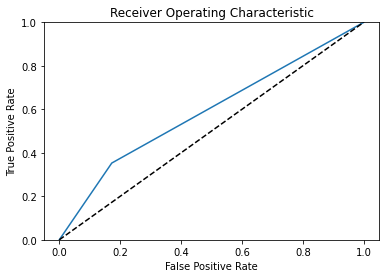

In [35]:
# Based on f1
evaluate_model(best_logreg_f1_model)

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0
 0 1 0 0 0 0 1 1 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5902636916835701
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        29
           1       0.55      0.35      0.43        17

    accuracy                           0.65        46
   macro avg       0.62      0.59      0.59        46
weighted avg       0.63      0.65      0.63        46

Confusion Matrix: 
 [[24  5]
 [11  6]]


LogisticRegression(C=1000000, n_jobs=3)

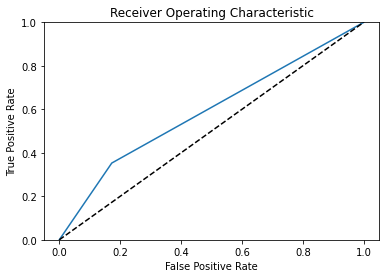

In [36]:
# Based on recall
evaluate_model(best_logreg_recall_model)

#### Decision Tree

In [37]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.32333333333333336 > best f1 = -1
depth: 1, leaf: 1: recall = 0.2845238095238095 > best recall = -1
depth: 1, leaf: 10: f1 = 0.39 > best f1 = 0.32333333333333336
depth: 1, leaf: 10: recall = 0.3345238095238095 > best recall = 0.2845238095238095
depth: 2, leaf: 17: recall = 0.4083333333333333 > best recall = 0.3345238095238095
depth: 2, leaf: 22: recall = 0.4416666666666666 > best recall = 0.4083333333333333
depth: 2, leaf: 23: recall = 0.4916666666666666 > best recall = 0.4416666666666666
depth: 3, leaf: 10: f1 = 0.44137085137085136 > best f1 = 0.39
depth: 3, leaf: 10: recall = 0.5178571428571429 > best recall = 0.4916666666666666
depth: 4, leaf: 9: recall = 0.5321428571428571 > best recall = 0.5178571428571429
depth: 4, leaf: 10: f1 = 0.4572438672438673 > best f1 = 0.44137085137085136
depth: 4, leaf: 10: recall = 0.5678571428571428 > best recall = 0.5321428571428571
depth: 5, leaf: 5: f1 = 0.4790764790764791 > best f1 = 0.4572438672438673
depth: 5, leaf: 5: re

[0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0
 1 1 0 1 0 0 1 0 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5456389452332657
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        29
           1       0.42      0.47      0.44        17

    accuracy                           0.57        46
   macro avg       0.54      0.55      0.54        46
weighted avg       0.58      0.57      0.57        46

Confusion Matrix: 
 [[18 11]
 [ 9  8]]


DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42)

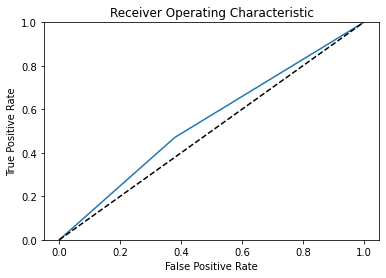

In [38]:
# Based on f1
evaluate_model(best_tree_f1_model)

[0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0
 1 1 0 1 0 0 1 0 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.5456389452332657
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        29
           1       0.42      0.47      0.44        17

    accuracy                           0.57        46
   macro avg       0.54      0.55      0.54        46
weighted avg       0.58      0.57      0.57        46

Confusion Matrix: 
 [[18 11]
 [ 9  8]]


DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42)

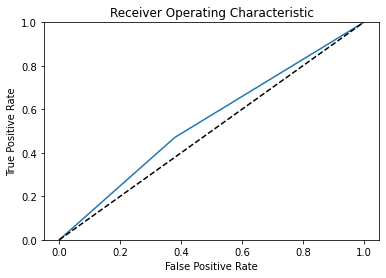

In [39]:
# Based on recall
evaluate_model(best_tree_recall_model)

#### Random Forest

In [40]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(30)

estimator: 1: f1 = 0.2866666666666667 > best f1 = -1
estimator: 1: recall = 0.32023809523809527 > best recall = -1
estimator: 13: f1 = 0.31787878787878787 > best f1 = 0.2866666666666667


[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0
 0 0 0 1 0 0 0 0 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.40872210953346855
              precision    recall  f1-score   support

           0       0.58      0.76      0.66        29
           1       0.12      0.06      0.08        17

    accuracy                           0.50        46
   macro avg       0.35      0.41      0.37        46
weighted avg       0.41      0.50      0.44        46

Confusion Matrix: 
 [[22  7]
 [16  1]]


RandomForestClassifier(n_estimators=13, random_state=42)

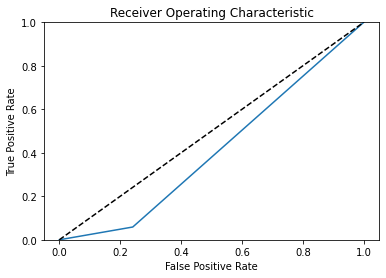

In [41]:
# Based on f1
evaluate_model(best_forest_f1_model)

[0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0
 0 1 0 1 0 0 0 0 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.462474645030426
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        29
           1       0.31      0.24      0.27        17

    accuracy                           0.52        46
   macro avg       0.46      0.46      0.46        46
weighted avg       0.50      0.52      0.51        46

Confusion Matrix: 
 [[20  9]
 [13  4]]


RandomForestClassifier(n_estimators=1, random_state=42)

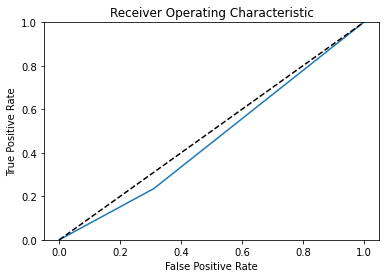

In [42]:
# Based on recall
evaluate_model(best_forest_recall_model)

#### SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   18.6s finished
[0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0
 0 0 0 0 0 1 1 1 1]
[0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 0]
AUC is:  0.6389452332657202
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        29
           1       0.53      0.59      0.56        17

    accuracy                           0.65        46
   macro avg       0.63      0.64      0.63        46
weighted avg       0.66      0.65      0.66        46

Confusion Matrix: 
 [[20  9]
 [ 7 10]]
Best SVM parameters: {'C': 100, 'kernel': 'linear'}


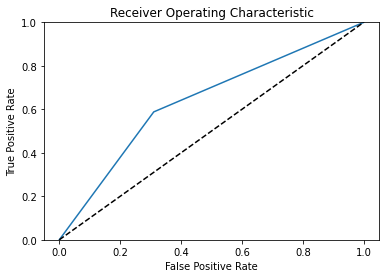

In [43]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")